In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner
import datetime

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
print("ori train ", poi_train_x.shape[0])
poi_train_x = np.matrix(poi_train_x.to_numpy())
print("matrix train ", len(poi_train_x))
poi_train_y = pd.read_csv('train_y.csv')
print("ori train y ", poi_train_y.shape[0])
poi_train_y = poi_train_y['Life Expectancy'].tolist()
print("matrix train y ", len(poi_train_y))
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

print (poi_train_x[0])
print (poi_train_y[0])

# num of poisoning points
poison_ct = 300
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

ori train  1319
matrix train  1319
ori train y  1319
matrix train y  1319
[[2.00900000e+03 0.00000000e+00 2.52077562e-01 2.22222222e-03
  1.14221725e-01 6.87422107e-04 9.79591837e-01 9.89711711e-05
  2.10892236e-01 1.60000000e-03 9.79166667e-01 1.74114916e-01
  9.79381443e-01 0.00000000e+00 1.80413125e-03 1.54066216e-05
  5.50724638e-01 5.36842105e-01 7.75316456e-01 6.47342995e-01]]
0.6736242884250474
Posion count:  300  Train count:  1319  Test count:  165  Proportion of poisoning:  0.1852995676343422


# Inverse Flip & Ridge Poisoner

y_opp [0. 0. 0. ... 0. 0. 0.]
stats [0. 0. 0. ... 0. 0. 0.]
total_prob 132.78026565464893
x_pois len:  300
x_pois col ct: 20
y_pois len:  300
classifier:  Ridge(alpha=0.1, max_iter=10000)
***************************
**** Poison Count: 51 ****
***************************
Iteration 0:
Objective Value: 0.03863729540581062 Change: 0.03863729540581062
Validation MSE: 0.004803762868319202
Test MSE: 0.006711774930312258
 
Iteration  1
Objective Value: 0.045915731479082275  Difference:  0.007278436073271652
 
Iteration  2
Objective Value: 0.04608856724572015  Difference:  0.00017283576663787437
 
Iteration  3
Objective Value: 0.04629202019934403  Difference:  0.00020345295362388105
 
Iteration  4
Objective Value: 0.04683221367259867  Difference:  0.0005401934732546382
 
Iteration  5
Objective Value: 0.04724363948464487  Difference:  0.0004114258120462011
 
Iteration  6
Objective Value: 0.04740213354909735  Difference:  0.00015849406445248015
 
Iteration  7
Objective Value: 0.047516700281986284

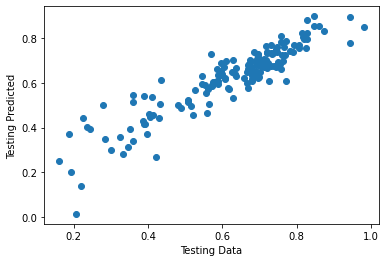

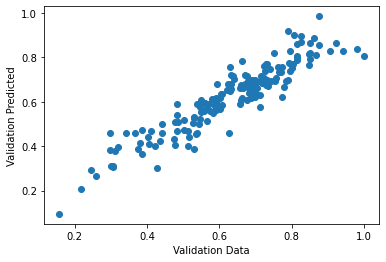

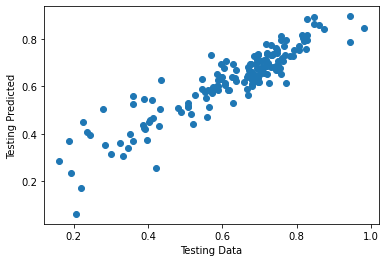

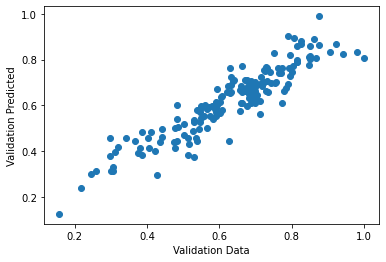

***************************
**** Poison Count: 106 ****
***************************
Iteration 0:
Objective Value: 0.03533228118070921 Change: 0.03533228118070921
Validation MSE: 0.008150080603999387
Test MSE: 0.011117660651202755
 
Iteration  1
Objective Value: 0.04607546101136032  Difference:  0.010743179830651109
 
Iteration  2
Objective Value: 0.04609712466179346  Difference:  2.166365043313606e-05
 
Iteration  3
Objective Value: 0.046118539103358926  Difference:  2.1414441565469067e-05
 
Iteration  4
Objective Value: 0.04614014197957395  Difference:  2.1602876215026656e-05
 
Iteration  5
Objective Value: 0.04616181708778532  Difference:  2.16751082113692e-05
 
Iteration  6
Objective Value: 0.04618311429808972  Difference:  2.129721030439541e-05
 
Iteration  7
Objective Value: 0.04620372723148713  Difference:  2.061293339741116e-05
 
Iteration  8
Objective Value: 0.0462242208030397  Difference:  2.049357155257253e-05
 
Iteration  9
Objective Value: 0.04624032328070273  Difference:  

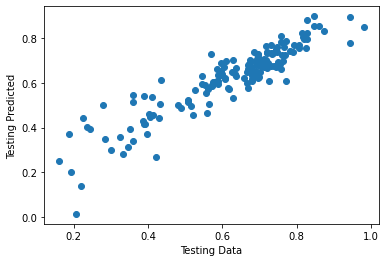

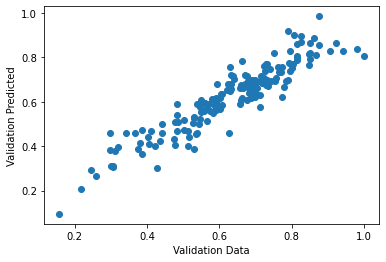

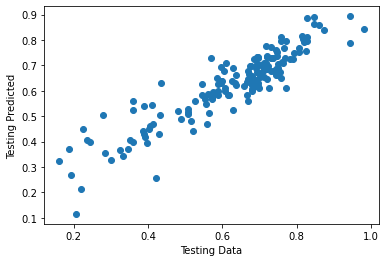

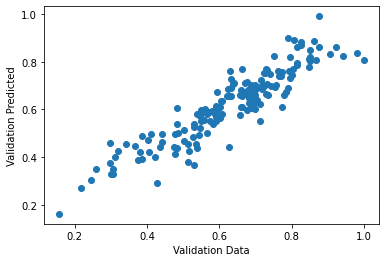

***************************
**** Poison Count: 165 ****
***************************
Iteration 0:
Objective Value: 0.03618640896557017 Change: 0.03618640896557017
Validation MSE: 0.012031439827172816
Test MSE: 0.015702148138968208
 
Iteration  1
Objective Value: 0.04675532098700987  Difference:  0.010568912021439704
 
Iteration  2
Objective Value: 0.0467838180813605  Difference:  2.849709435062686e-05
 
Iteration  3
Objective Value: 0.04681235723441672  Difference:  2.853915305622151e-05
 
Iteration  4
Objective Value: 0.04684093573558898  Difference:  2.8578501172257798e-05
 
Iteration  5
Objective Value: 0.04686953601477925  Difference:  2.860027919027175e-05
 
Iteration  6
Objective Value: 0.04689798951855256  Difference:  2.845350377331246e-05
 
Iteration  7
Objective Value: 0.04692620754861697  Difference:  2.821803006440582e-05
 
Iteration  8
Objective Value: 0.046958568788973705  Difference:  3.23612403567361e-05
 
Iteration  9
Objective Value: 0.04696267614898755  Difference:  4

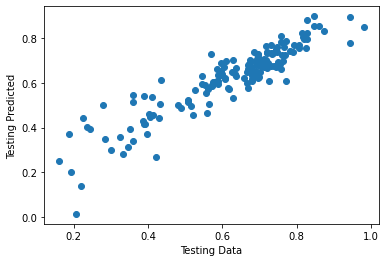

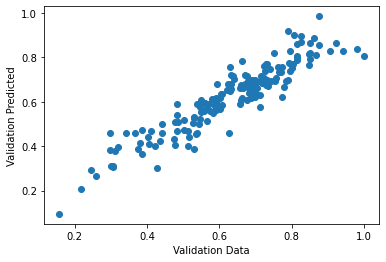

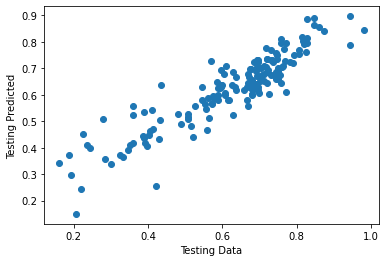

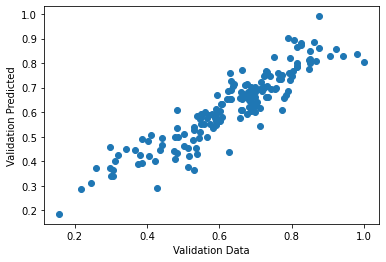

***************************
**** Poison Count: 230 ****
***************************
Iteration 0:
Objective Value: 0.03665970336581301 Change: 0.03665970336581301
Validation MSE: 0.016904707286205894
Test MSE: 0.020739191253304545
 
Iteration  1
Objective Value: 0.04775031149776085  Difference:  0.011090608131947843
 
Iteration  2
Objective Value: 0.0477850798831588  Difference:  3.476838539794719e-05
 
Iteration  3
Objective Value: 0.04781994514871407  Difference:  3.4865265555274194e-05
 
Iteration  4
Objective Value: 0.0478545883302941  Difference:  3.464318158002966e-05
 
Iteration  5
Objective Value: 0.047889318077009954  Difference:  3.472974671585305e-05
 
Iteration  6
Objective Value: 0.04792409325564828  Difference:  3.477517863832713e-05
 
Iteration  7
Objective Value: 0.047942219760980495  Difference:  1.8126505332213827e-05
 
Iteration  8
Objective Value: 0.04794930616552269  Difference:  7.08640454219478e-06
 
Iteration  9
Objective Value: 0.04795626442682775  Difference:  

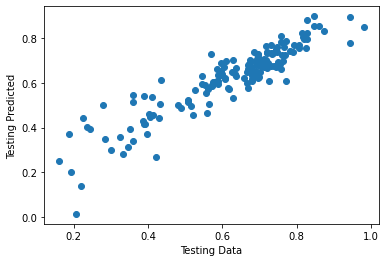

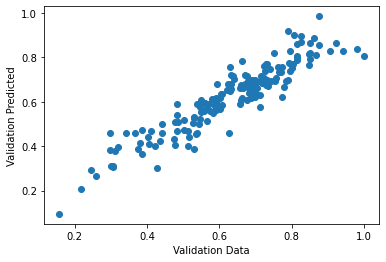

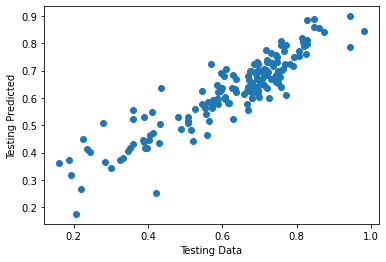

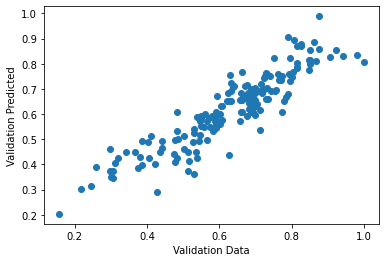

***************************
**** Poison Count: 300 ****
***************************
Iteration 0:
Objective Value: 0.04316161798431159 Change: 0.04316161798431159
Validation MSE: 0.022049082676473115
Test MSE: 0.02617726359351904
 
Iteration  1
Objective Value: 0.04746742270679876  Difference:  0.004305804722487171
 
Iteration  2
Objective Value: 0.04750586295818142  Difference:  3.844025138265844e-05
 
Iteration  3
Objective Value: 0.04754432304004205  Difference:  3.846008186063343e-05
 
Iteration  4
Objective Value: 0.04758315475332398  Difference:  3.8831713281929636e-05
 
Iteration  5
Objective Value: 0.0476235889581199  Difference:  4.043420479591525e-05
 
Iteration  6
Objective Value: 0.04764451159551279  Difference:  2.0922637392895016e-05
 
Iteration  7
Objective Value: 0.047640280234169434  Difference:  -4.231361343358386e-06
NO PROGRESS MADE!
 
Iteration  8
Objective Value: 0.047639634069554446  Difference:  -4.8775259583466735e-06
NO PROGRESS MADE!
 
Iteration  9
Objective V

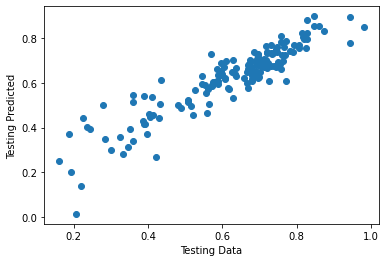

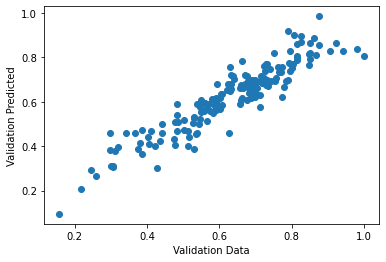

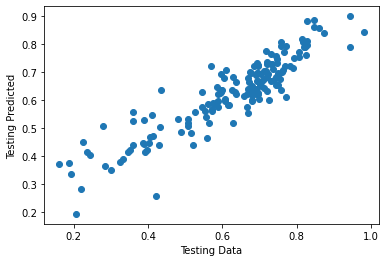

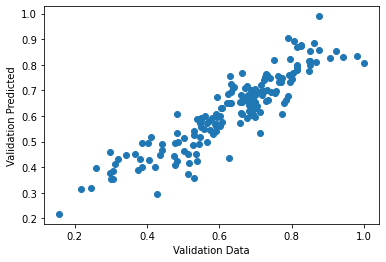


After Flipping, Unpoisoned
Validation MSE: 0.003724973370127055
Test MSE: 0.004722250058956821
Poisoned:
Validation MSE: 0.004809270034238092
Test MSE: 0.005527821692453286


In [3]:
# flip the data
x_pois, y_pois = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)

# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
poiser = gd_poisoner.ridge_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    err_unpoised = poiser.compute_error(classifier,True)
    err = poiser.compute_error(classifier_poised,True)

'''
print("poi_train_x ", len(poi_train_x),\
            ", poi_train_y ", len(poi_train_y),\
            ", poi_test_x", len(poi_test_x),\
            ", poi_test_y", len(poi_test_y),\
            ", poi_val_x", len(poi_val_x),\
            ", poi_val_y", len(poi_val_y))
'''
print("")
print("After Flipping, Unpoisoned")
print("Validation MSE:", err_unpoised[0])
print("Test MSE:", err_unpoised[1])
print('Poisoned:')
print("Validation MSE:", err[0])
print("Test MSE:", err[1])

# B Flip & Ridge Poisoner

classifier:  Ridge(alpha=0.1, max_iter=10000)
***************************
**** Poison Count: 51 ****
***************************
Iteration 0:
Objective Value: 0.04601158901640725 Change: 0.04601158901640725
Validation MSE: 0.004534954662131399
Test MSE: 0.0057300028492425735
 
Iteration  1
Objective Value: 0.08148976336974344  Difference:  0.03547817435333619
 
Iteration  2
Objective Value: 0.07778534395279775  Difference:  -0.0037044194169456868
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.07886410626884108  Difference:  -0.0026256571009023594
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.07963298573412332  Difference:  -0.001856777635620116
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.0802093993025273  Difference:  -0.0012803640672161415
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.08063967066724793  Difference:  -0.000850092702495503
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.08091112065682542  Difference:  -0.0005786427129180205
NO PROGRESS MADE!

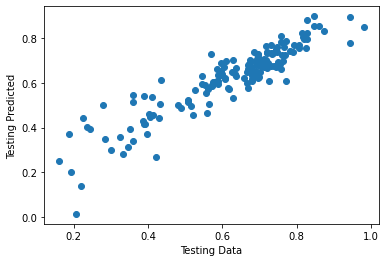

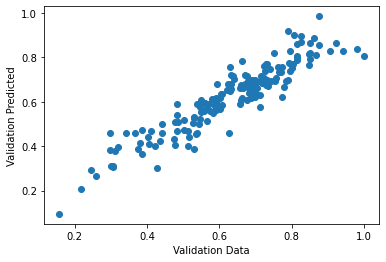

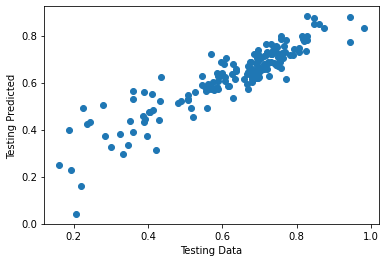

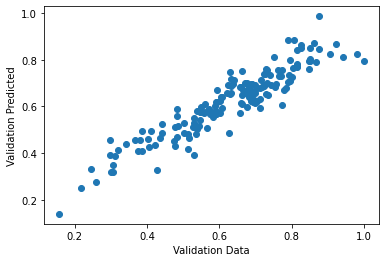

***************************
**** Poison Count: 106 ****
***************************
Iteration 0:
Objective Value: 0.04183546327133302 Change: 0.04183546327133302
Validation MSE: 0.0063665044726002274
Test MSE: 0.007406043172537913
 
Iteration  1
Objective Value: 0.04436251286666411  Difference:  0.0025270495953310865
 
Iteration  2
Objective Value: 0.04439662381842155  Difference:  3.411095175744061e-05
 
Iteration  3
Objective Value: 0.044430853781491635  Difference:  3.422996307008569e-05
 
Iteration  4
Objective Value: 0.044465144834143246  Difference:  3.429105265161103e-05
 
Iteration  5
Objective Value: 0.04449949965298084  Difference:  3.435481883759528e-05
 
Iteration  6
Objective Value: 0.04453391462853053  Difference:  3.4414975549686144e-05
 
Iteration  7
Objective Value: 0.0445683853446138  Difference:  3.447071608327079e-05
 
Iteration  8
Objective Value: 0.04460291215961472  Difference:  3.452681500092092e-05
 
Iteration  9
Objective Value: 0.044637498453301755  Differenc

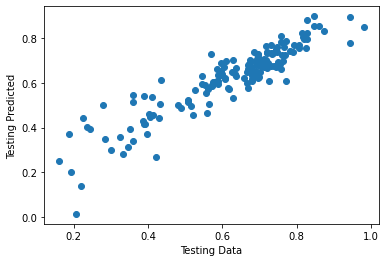

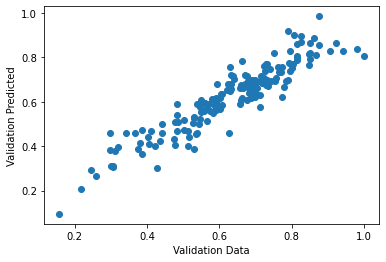

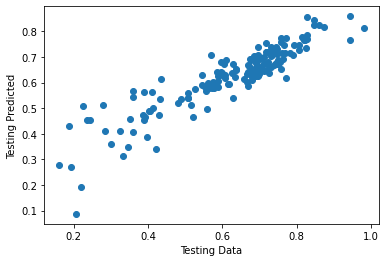

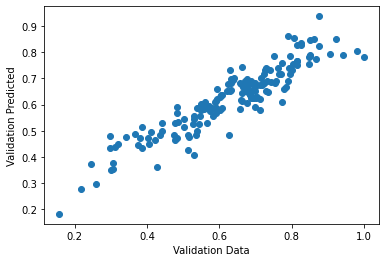

***************************
**** Poison Count: 165 ****
***************************
Iteration 0:
Objective Value: 0.0413145305240192 Change: 0.0413145305240192
Validation MSE: 0.009504583787738856
Test MSE: 0.010238901250403392
 
Iteration  1
Objective Value: 0.04186651827161619  Difference:  0.000551987747596995
 
Iteration  2
Objective Value: 0.04191783043250865  Difference:  5.131216089245688e-05
 
Iteration  3
Objective Value: 0.04196937767486327  Difference:  5.154724235462149e-05
 
Iteration  4
Objective Value: 0.042021048699738314  Difference:  5.167102487504266e-05
 
Iteration  5
Objective Value: 0.042072843138376226  Difference:  5.1794438637911555e-05
 
Iteration  6
Objective Value: 0.042124761145363426  Difference:  5.1918006987200505e-05
 
Iteration  7
Objective Value: 0.04217680195731062  Difference:  5.204081194719323e-05
 
Iteration  8
Objective Value: 0.04222896296519765  Difference:  5.216100788703326e-05
 
Iteration  9
Objective Value: 0.04228124334065077  Difference:

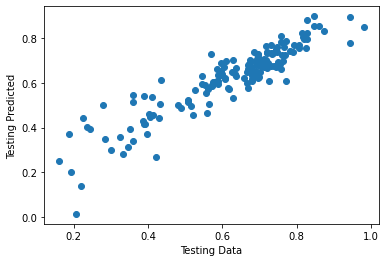

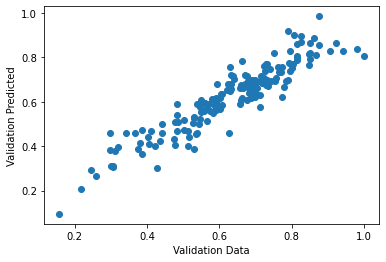

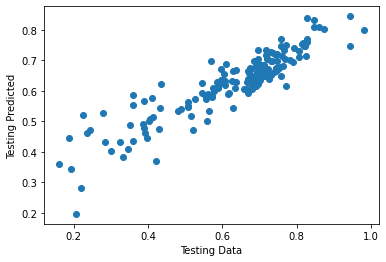

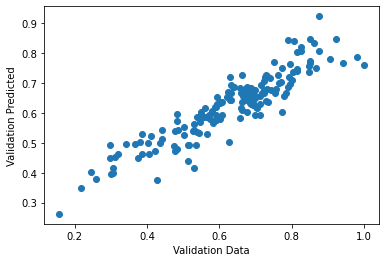

***************************
**** Poison Count: 230 ****
***************************
Iteration 0:
Objective Value: 0.04710522083040872 Change: 0.04710522083040872
Validation MSE: 0.014162544710017223
Test MSE: 0.014425203390531528
 
Iteration  1
Objective Value: 0.044122841667173576  Difference:  -0.002982379163235141
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.04401124290142648  Difference:  -0.003093977928982236
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.04392767893439716  Difference:  -0.0031775418960115556
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.0438650828805473  Difference:  -0.003240137949861416
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.04381817766195792  Difference:  -0.0032870431684507984
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.04378302384488876  Difference:  -0.003322196985519957
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.043756672642717376  Difference:  -0.0033485481876913414
NO PROGRESS MADE!
 
Iteration  8
Objective

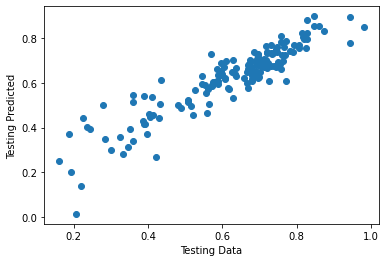

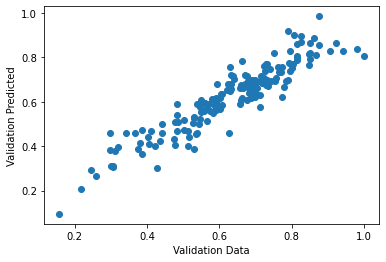

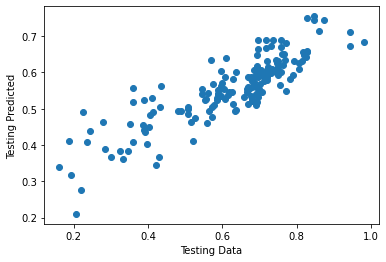

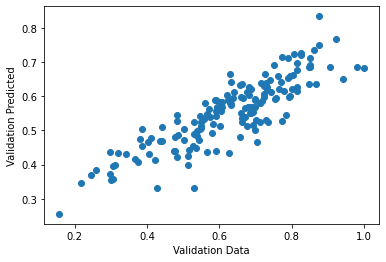

***************************
**** Poison Count: 300 ****
***************************
Iteration 0:
Objective Value: 0.04939673980316221 Change: 0.04939673980316221
Validation MSE: 0.018252953460945864
Test MSE: 0.0187037409371694
 
Iteration  1
Objective Value: 0.03635689075076928  Difference:  -0.01303984905239293
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.03635687859195757  Difference:  -0.013039861211204644
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.03635686947285324  Difference:  -0.01303987033030897
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.03635686263352878  Difference:  -0.01303987716963343
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.03635685750403586  Difference:  -0.013039882299126351
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.03635685365691764  Difference:  -0.013039886146244573
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.036356850771579345  Difference:  -0.013039889031582867
NO PROGRESS MADE!
 
Iteration  8
Objective Value: 

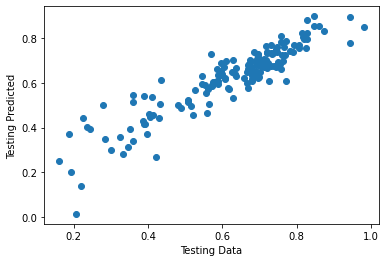

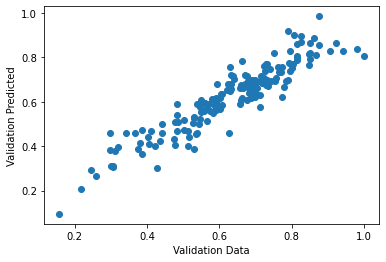

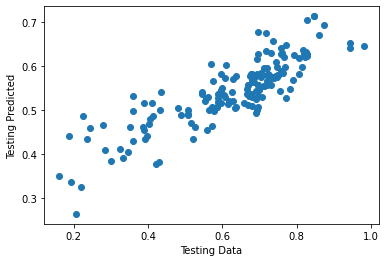

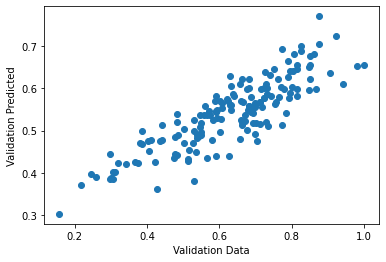


After Flipping, Unpoisoned
Validation MSE: 0.003724973370127055
Test MSE: 0.004722250058956821
Poisoned:
Validation MSE: 0.018252953460945864
Test MSE: 0.0187037409371694


In [4]:
# flip the data
x_pois, y_pois = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
poiser = gd_poisoner.ridge_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    err_unpoised = poiser.compute_error(classifier,True)
    err = poiser.compute_error(classifier_poised,True)

'''
print("poi_train_x ", len(poi_train_x),\
            ", poi_train_y ", len(poi_train_y),\
            ", poi_test_x", len(poi_test_x),\
            ", poi_test_y", len(poi_test_y),\
            ", poi_val_x", len(poi_val_x),\
            ", poi_val_y", len(poi_val_y))
'''
print("")
print("After Flipping, Unpoisoned")
print("Validation MSE:", err_unpoised[0])
print("Test MSE:", err_unpoised[1])
print('Poisoned:')
print("Validation MSE:", err[0])
print("Test MSE:", err[1])